<a href="https://colab.research.google.com/github/zd2011/responsible_ds/blob/main/hw1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
!pip install fairlearn

In [ ]:
#@markdown Load modules
import numpy as np
from IPython.display import display, Markdown, Latex
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score

from fairlearn.postprocessing import ThresholdOptimizer
from fairlearn.preprocessing import CorrelationRemover
from fairlearn.adversarial import AdversarialFairnessClassifier
from fairlearn.metrics import MetricFrame
import fairlearn.datasets as fdata
from fairlearn.metrics import (demographic_parity_difference, demographic_parity_ratio, 
                               selection_rate_difference, false_negative_rate_difference, 
                               false_positive_rate_difference, equalized_odds_ratio,
                               false_negative_rate, false_positive_rate)

# Question 2

## a) Suppose that both groups A and B have equal false positive rates and equal false negative rates where FPR = 0.4 and FNR = 0.75. What are each of their respective values for TP, FN, FP, TN?

For $p_A = 0.8$ and $p_B = 0.5$, and $n_A = 100,n_B = 80$, we have $FPR = \frac{FP}{FP+TN} = 0.4, FNR = \frac{FN}{FN+TP} = 0.75$ for both group.

For Group A, there are $p_A * n_A = 80$ members with positive outcome, 20 members with neative outcome. Like wise there are $p_B * n_B = 40$ members with positive outcome, 40 members with neative outcome for Group B.

Then using FPR and FNR formulas, for Group A, $\frac{FP_A}{20} = 0.4→FP_A = 8$ and $TN_A = 20-FP_A = 16$

$\frac{FN_A}{80} = 0.75→FN_A = 60$ and $TP_A = 80-FN_A = 20$

For Group B, $\frac{FP_B}{40} = 0.4→FP_B = 16$ and $TN_B = 40-FP_B = 24$. 

$\frac{FN_B}{40} = 0.75→FN_B = 30$ and $TP_B = 40-FN_B = 10$.

## b) What is the accuracy (ACC) for group A and group B? Which group has better accuracy?

Using the confusion matrix calculated above, Group A has accuracy $ACC_A = \frac{(TP_A+TN_A)}{P_A+N_A} = \frac{32}{100} = 0.32$. Group B has accuracy $ACC_B = \frac{(TP_B+TN_B)}{P_B+N_B} = \frac{34}{80} = 0.425$. 

## c) What is the positive predictive value for group A and group B? Which group has better PPV?

Using the formula $PPV = \frac{TP}{PP}$ fpr both groups, Group A has

$PPV_A = \frac{20}{28} = 0.7143$

Group B has

$PPV_B = \frac{10}{26} = 0.3846$

## d) How does this example show the fairness impossibility results described in the Chouldechova paper?

As we shown above, and as the question stated, when the base rate for outcome of interest is different across groups ($p_A \ne p_B$), while FPR and FNR is equal, we obtained a different positive predictive value as shown in c), thus corroborates Chouldechova's claim.

# Load and preprocess the data

In [ ]:
#@markdown Load and read about the dataset.
# get datast from fairlearn and show description
dataset = fdata.fetch_diabetes_hospital()

display(Markdown(dataset.DESCR))

# save dataframe and features
x_raw = dataset.data
# y_raw = np.array(dataset.target)
feature_names = dataset.feature_names

The "Diabetes 130-Hospitals" dataset represents 10 years of clinical care at 130 U.S. hospitals and delivery networks, collected from 1999 to 2008. Each record represents the hospital admission record for a patient diagnosed with diabetes whose stay lasted between one to fourteen days. The features describing each encounter include demographics, diagnoses, diabetic medications, number of visits in the year preceding the encounter, and payer information, as well as whether the patient was readmitted after release, and whether the readmission occurred within 30 days of the release.

The original "Diabetes 130-Hospitals" dataset was collected by Beata Strack, Jonathan P. DeShazo, Chris Gennings, Juan L. Olmo, Sebastian Ventura, Krzysztof J. Cios, and John N. Clore in 2014.

This version of the dataset was derived by the Fairlearn team for the SciPy 2021 tutorial "Fairness in AI Systems: From social context to practice using Fairlearn". In this version, the target variable "readmitted" is binarized into whether the patient was re-admitted within thirty days. The full dataset pre-processing script can be found on GitHub: https://github.com/fairlearn/talks/blob/main/2021_scipy_tutorial/preprocess.py

Downloaded from openml.org.

You can read more about the dataset [here](https://fairlearn.org/main/user_guide/datasets/diabetes_hospital_data.html). In this description, we see that two features, `readmitted` and `readmit_binary`, are other representations of the same outcome, so we drop them from the set of predictors.

In [ ]:
#@markdown Down sample to make runtimes reasonable
x_raw = x_raw.sample(frac=0.1, random_state=123)

In [ ]:
y_raw = x_raw['readmit_binary']
x_raw = x_raw.drop(columns=['readmitted', 'readmit_binary'])
feature_names = feature_names[:-2]

In [ ]:
#@markdown Look at the first few rows of the data.
x_raw.head()

,race,gender,age,discharge_disposition_id,admission_source_id,time_in_hospital,medical_specialty,num_lab_procedures,num_procedures,num_medications,...,max_glu_serum,A1Cresult,insulin,change,diabetesMed,medicare,medicaid,had_emergency,had_inpatient_days,had_outpatient_days
65884,Caucasian,Male,Over 60 years,Discharged to Home,Emergency,3.0,Missing,49.0,6.0,27.0,...,None,None,Up,Ch,Yes,False,False,False,True,False
86278,Caucasian,Female,Over 60 years,Other,Referral,5.0,Missing,57.0,0.0,21.0,...,None,None,No,Ch,Yes,True,False,False,True,False
30000,Caucasian,Male,30-60 years,Discharged to Home,Other,4.0,Other,37.0,2.0,9.0,...,None,None,No,No,No,False,False,False,False,False
51185,Caucasian,Male,30-60 years,Other,Other,9.0,InternalMedicine,61.0,6.0,27.0,...,None,>8,No,Ch,Yes,False,False,True,False,True
53902,Caucasian,Female,30-60 years,Discharged to Home,Referral,7.0,Other,23.0,0.0,13.0,...,None,None,No,No,Yes,True,False,True,True,False


## data inspectation 

In [ ]:
#@markdown drop the rows with 'Unknown/Invalid' values for gender

# drop these 3 rows
print(x_raw.shape)
rows_to_keep = x_raw.gender != 'Unknown/Invalid'
x_raw = x_raw[rows_to_keep]
y_raw = y_raw[rows_to_keep]
print(x_raw.shape)

(10177, 22)
(10177, 22)


In [ ]:
#@markdown
unique_feature_values = x_raw.apply(np.unique, axis=0)
unique_feature_values

race                        [AfricanAmerican, Asian, Caucasian, Hispanic, ...
gender                                                         [Female, Male]
age                         [30 years or younger, 30-60 years, Over 60 years]
discharge_disposition_id                          [Discharged to Home, Other]
admission_source_id                              [Emergency, Other, Referral]
time_in_hospital            [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, ...
medical_specialty           [Cardiology, Emergency/Trauma, Family/GeneralP...
num_lab_procedures          [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, ...
num_procedures                            [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0]
num_medications             [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, ...
primary_diagnosis           [Diabetes, Genitourinary Issues, Musculoskelet...
number_diagnoses            [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, ...
max_glu_serum                                        [>200, >300

In [ ]:
#@markdown
binary_features = unique_feature_values.index[[len(x) == 2 for x in unique_feature_values]].values
print(f'Binary features: {binary_features}')
categorical_features = unique_feature_values.index[[len(x) > 2 and isinstance(x[0], str) for x in unique_feature_values]].values
print(f'Categorical features: {categorical_features}')

Binary features: ['gender' 'discharge_disposition_id' 'change' 'diabetesMed' 'medicare'
 'medicaid' 'had_emergency' 'had_inpatient_days' 'had_outpatient_days']
Categorical features: ['race' 'age' 'admission_source_id' 'medical_specialty'
 'primary_diagnosis' 'max_glu_serum' 'A1Cresult' 'insulin']


In [ ]:
#@markdown standardize data types 
for col_name in feature_names:
    if col_name in categorical_features:
        x_raw[col_name] = x_raw[col_name].astype('category')
    elif col_name in binary_features:  # redundant for clarity
        # turn into int column
        integer_col = (x_raw[col_name] == unique_feature_values[col_name][0]).astype(int)
        new_name = f'{col_name}_{unique_feature_values[col_name][0]}'
        x_raw[new_name] = integer_col
        x_raw.drop(columns=[col_name], inplace=True) 

In [ ]:
%%capture
#@markdown
x_raw.apply(np.unique, axis=0)

In [ ]:
x_raw.dtypes

race                                           category
age                                            category
admission_source_id                            category
time_in_hospital                                float64
medical_specialty                              category
num_lab_procedures                              float64
num_procedures                                  float64
num_medications                                 float64
primary_diagnosis                              category
number_diagnoses                                float64
max_glu_serum                                  category
A1Cresult                                      category
insulin                                        category
gender_Female                                     int32
discharge_disposition_id_Discharged to Home       int32
change_Ch                                         int32
diabetesMed_No                                    int32
medicare_False                                  

In [ ]:
#@markdown One-hot encode categorical features
x_numeric = pd.get_dummies(x_raw)
display(x_numeric.head())

# get one-hot and numeric column names
numeric_cols = x_numeric.dtypes.index[x_numeric.dtypes == 'int64'].values
one_hot_cols = x_numeric.dtypes.index[x_numeric.dtypes != 'int64'].values

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_diagnoses,gender_Female,discharge_disposition_id_Discharged to Home,change_Ch,diabetesMed_No,medicare_False,...,max_glu_serum_None,max_glu_serum_Norm,A1Cresult_>7,A1Cresult_>8,A1Cresult_None,A1Cresult_Norm,insulin_Down,insulin_No,insulin_Steady,insulin_Up
65884,3.0,49.0,6.0,27.0,9.0,0,1,1,0,1,...,1,0,0,0,1,0,0,0,0,1
86278,5.0,57.0,0.0,21.0,9.0,1,0,1,0,0,...,1,0,0,0,1,0,0,1,0,0
30000,4.0,37.0,2.0,9.0,5.0,0,1,0,1,1,...,1,0,0,0,1,0,0,1,0,0
51185,9.0,61.0,6.0,27.0,9.0,0,0,1,0,1,...,1,0,0,1,0,0,0,1,0,0
53902,7.0,23.0,0.0,13.0,7.0,1,1,0,0,0,...,1,0,0,0,1,0,0,1,0,0


 # TODO: Split train, test data 80 train / 20 test 


In [ ]:
# write your code here 

X_train, X_test, y_train, y_test = train_test_split(x_numeric, y_raw, test_size=0.2, random_state=0)

# Problem 2, Part (a) 
### **Train a baseline Random Forest (RF) (sklearn RandomForestClassifier) model and report metrics**

### Train a random forest model - Baseline

In [ ]:
# write your code here 
# initialize a model with RandomForestClassifier 
n_estimators = 1

clf_baseline = RandomForestClassifier(n_estimators = 1)

# train the model with the training data split
clf_baseline.fit(X_train, y_train)

RandomForestClassifier(n_estimators=1)

### Report metrics

Calculate metrics with Fairlearn MetricFrame


In [ ]:
# write your code here 

# get model's prediction for the test set
y_pred_baseline = clf_baseline.predict(X_test)

# use MetricFrame to get the results 
sensitive_feature = X_test.gender_Female

metric_dict = {'accuracy': accuracy_score,
           'precision': precision_score, 
           'recall': recall_score,
           'FNR': false_negative_rate,
           'FPR': false_positive_rate}
sample_params = {}

metric_frame_baseline = MetricFrame(metrics=metric_dict,
                             y_true=y_test,
                             y_pred=y_pred_baseline,
                             sensitive_features=sensitive_feature)

In [ ]:
#metric i-v for men and women
metric_frame_baseline.by_group

,accuracy,precision,recall,FNR,FPR
gender_Female,,,,,
0,0.538883,0.480769,0.493827,0.506173,0.425197
1,0.528940,0.497207,0.507605,0.492395,0.452261


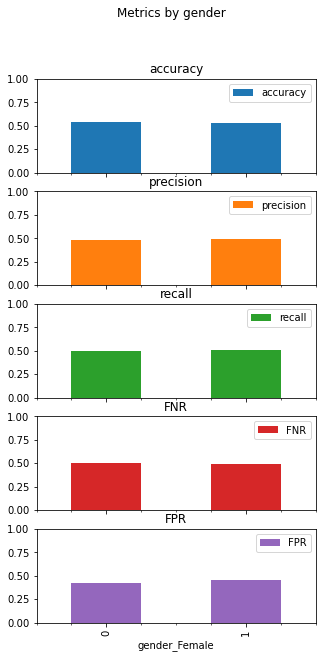

In [ ]:
metric_frame_baseline.by_group.plot.bar(
    subplots=True, 
    figsize=(5, 10), 
    ylim=[0,1],
    title="Metrics by gender",
    )
plt.show()

Print Results

In [ ]:
#metriv i-v for overall
metric_frame_baseline.overall

accuracy     0.533399
precision    0.490031
recall       0.501611
FNR          0.498389
FPR          0.439819
dtype: float64

In [ ]:
#compute fairness metrics
fnr_diff_baseline = false_negative_rate_difference(y_test, y_pred_baseline, sensitive_features=X_test.gender_Female)
fpr_diff_baseline = false_positive_rate_difference(y_test, y_pred_baseline, sensitive_features=X_test.gender_Female)
demo_parity_ratio_baseline = demographic_parity_ratio(y_test, y_pred_baseline, sensitive_features=X_test.gender_Female)
eq_odds_ratio_baseline = equalized_odds_ratio(y_test, y_pred_baseline, sensitive_features=X_test.gender_Female)
selection_rate_diff_baseline = selection_rate_difference(y_test, y_pred_baseline, sensitive_features=X_test.gender_Female)

#metric vi-x for overall
print(f'false negative rate difference: {fnr_diff_baseline:.4f}')
print(f'false positive rate difference: {fpr_diff_baseline:.4f}')
print(f'demographic parity ratio: {demo_parity_ratio_baseline:.4f}')
print(f'equalized odds ratio: {eq_odds_ratio_baseline:.4f}')
print(f'selection rate difference: {selection_rate_diff_baseline:.4f}')

false negative rate difference: 0.0138
false positive rate difference: 0.0271
demographic parity ratio: 0.9529
equalized odds ratio: 0.9402
selection rate difference: 0.0225


Using the baseline random forest with n_estimator = 1, obtained metrics, which are displyed as above. Since accuracy, precision, recall, FNR, and FPR and all around 0.5, true positive, true negative, false positive, and false negative have approximately the same case. While there is not much predictive power to the baseline random forest model (we are doing slightly better than random guess), we do get relatively equal metrics considering our sensitive attribute. Accuracy, precision, recall, FNR, FPR does not have significant gaps between male and female. Overall metrics VI-X further corroborate with the graph of metric by gender.

# Problem 2, Part (b)

Train another classifier with the following value of hyperparameters

In [ ]:
# write your code here 
n_estimators = 1000
max_depth = 10
# initialize a model with RandomForestClassifier 
clf = RandomForestClassifier(n_estimators = 1000, max_depth = 10)

# train the model with the training data split
clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, n_estimators=1000)

Calculate metrics with Fairlearn MetricFrame
and print the results

In [ ]:
# get model's prediction for the test set
y_pred = clf.predict(X_test)

# use MetricFrame to get the results 
sensitive_feature = X_test.gender_Female

metric_dict = {'accuracy': accuracy_score,
           'precision': precision_score, 
           'recall': recall_score,
           'FNR': false_negative_rate,
           'FPR': false_positive_rate}
sample_params = {}

metric_frame = MetricFrame(metrics=metric_dict,
                             y_true=y_test,
                             y_pred=y_pred,
                             sensitive_features=sensitive_feature)

In [ ]:
metric_frame.by_group

,accuracy,precision,recall,FNR,FPR
gender_Female,,,,,
0,0.618839,0.601423,0.417284,0.582716,0.220472
1,0.634907,0.636792,0.513308,0.486692,0.257956


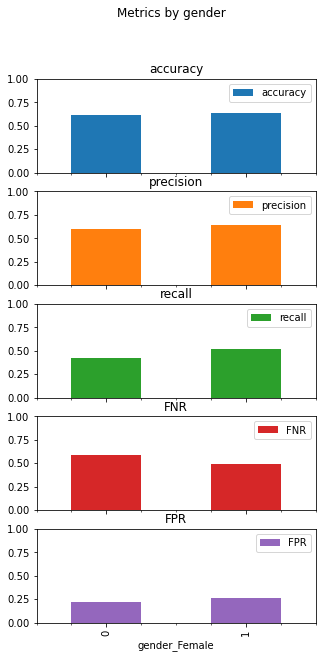

In [ ]:
metric_frame.by_group.plot.bar(
    subplots=True, 
    figsize=(5, 10), 
    ylim=[0,1],
    title="Metrics by gender",
    )
plt.show()

In [ ]:
metric_frame.overall

accuracy     0.627701
precision    0.622695
recall       0.471536
FNR          0.528464
FPR          0.240724
dtype: float64

In [ ]:
#compute fairness metrics
fnr_diff = false_negative_rate_difference(y_test, y_pred, sensitive_features=X_test.gender_Female)
fpr_diff = false_positive_rate_difference(y_test, y_pred, sensitive_features=X_test.gender_Female)
demo_parity_ratio = demographic_parity_ratio(y_test, y_pred, sensitive_features=X_test.gender_Female)
eq_odds_ratio = equalized_odds_ratio(y_test, y_pred, sensitive_features=X_test.gender_Female)
selection_rate_diff = selection_rate_difference(y_test, y_pred, sensitive_features=X_test.gender_Female)

print(f'false negative rate difference: {fnr_diff:.4f}')
print(f'false positive rate difference: {fpr_diff:.4f}')
print(f'demographic parity ratio: {demo_parity_ratio:.4f}')
print(f'equalized odds ratio: {eq_odds_ratio:.4f}')
print(f'selection rate difference: {selection_rate_diff:.4f}')

false negative rate difference: 0.0960
false positive rate difference: 0.0375
demographic parity ratio: 0.8152
equalized odds ratio: 0.8129
selection rate difference: 0.0698


For our optimized random forest model,the accuracy improved to 62.57% Compared to the baseline model, we see an improvement in precision but a significant drop in FPR. However there is a drop in the performance of overall metrics VI-X. We see an increase in false negative rate difference, false positive rate difference, and selection rate difference. The demographic parity ratio and equalized odds ratio is also further away from 1. 

Looking at hyperparameters, we see that n_estimator changed from 1 (baseline estimator) to 1000, and the maximum depth of the tree is also increased. Logically, increasing the number of trees and the complexity of nodes in the trees could increase the accuracy of our predcition model. But improving accuracy might in term be fitting more to our training data. If the dataset has underlying bias, then fairness metric would perform worse than a baseline model.

In conlcusion, the accuracy optimized random forest model suggests a tradeoff between accuracy and performance of fairness metrics.

# Problem 2, Part (c) 
### **Fit Fairlean Adversarial Debiaser**

Experiment with the alpha parameter - which value of alpha produces the fairest and most accurate classifier? Does such a value exist?

In [ ]:
#@markdown Fit the AdversarialFairnessClassifier here.

#@markdown Use these hyperparameters, while varying the `alpha` parameter:
#@markdown - backend='tensorflow',
#@markdown - predictor_model=[128,64,32,16,8],
#@markdown - adversary_model=[32,16,8],
#@markdown - learning_rate=0.001,
#@markdown - epochs=3,
#@markdown - batch_size=16,
#@markdown - constraints='demographic_parity',
#@markdown - random_state=seed,
#@markdown - shuffle=True

cfl_af = AdversarialFairnessClassifier(backend='tensorflow',
  predictor_model=[128,64,32,16,8],
  adversary_model=[32,16,8],
  learning_rate=0.001,
  alpha = 1,
  epochs=3,
  batch_size=16,
  constraints='demographic_parity',
  random_state= 0,
  shuffle=True)

cfl_af.fit(X_train, y_train, sensitive_features = X_train.gender_Female)

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


AdversarialFairnessClassifier(adversary_model=[32, 16, 8], alpha=1,
                              backend='tensorflow', batch_size=16, epochs=3,
                              predictor_model=[128, 64, 32, 16, 8],
                              random_state=0, shuffle=True)

In [ ]:
y_pred_af = cfl_af.predict(X_test)

# use MetricFrame to get the results 
sensitive_feature = X_test.gender_Female

metric_dict = {'accuracy': accuracy_score,
           'precision': precision_score, 
           'recall': recall_score,
           'FNR': false_negative_rate,
           'FPR': false_positive_rate}
sample_params = {}

metric_frame_af = MetricFrame(metrics=metric_dict,
                             y_true=y_test,
                             y_pred=y_pred_af,
                             sensitive_features=sensitive_feature)

In [ ]:
metric_frame_af.overall

accuracy     0.590864
precision    0.681481
recall       0.197637
FNR          0.802363
FPR          0.077828
dtype: float64

In [ ]:
arr_test = np.append(metric_frame_af.overall, [1])
arr_test

array([0.59086444, 0.68148148, 0.19763695, 0.80236305, 0.07782805,
       1.        ])

In [ ]:
metric_frame_af.by_group

,accuracy,precision,recall,FNR,FPR
gender_Female,,,,,
0,0.589266,0.622951,0.187654,0.812346,0.090551
1,0.592164,0.729730,0.205323,0.794677,0.067002


In [ ]:
#range of alpha we test
alpha_range = [0.0, 0.3, 0.7, 1.0]

#create table to store values for overall and sensitive data specific
df_af_overall = pd.DataFrame(columns = ['accuracy','precision','recall','FNR','FPR',
  'fnr_diff','fpr_diff','demo_parity_ratio','eq_odds_ratio','selection_rate_diff'])
df_af_sen = pd.DataFrame(columns = ['accuracy','precision','recall','FNR','FPR','alpha','random_seed'])

for i in range(0,10):
  for j in alpha_range:

    #initiate model with specified seed and alpha
    cfl_af = AdversarialFairnessClassifier(backend='tensorflow',
      predictor_model=[128,64,32,16,8],
      adversary_model=[32,16,8],
      learning_rate=0.001,
      alpha = j,
      epochs=3,
      batch_size=16,
      constraints='demographic_parity',
      random_state= i,
      shuffle=True)

    #fit training data
    cfl_af.fit(X_train, y_train, sensitive_features = X_train.gender_Female)
    #predict using test data
    y_pred_af = cfl_af.predict(X_test)

    #report fairness metric i-v
    metric_frame_af = MetricFrame(metrics=metric_dict,
                             y_true=y_test,
                             y_pred=y_pred_af,
                             sensitive_features=sensitive_feature)
    #fairness metric vi-x
    fnr_diff_af = false_negative_rate_difference(y_test, y_pred_af, sensitive_features=X_test.gender_Female)
    fpr_diff_af = false_positive_rate_difference(y_test, y_pred_af, sensitive_features=X_test.gender_Female)
    demo_parity_ratio_af = demographic_parity_ratio(y_test, y_pred_af, sensitive_features=X_test.gender_Female)
    eq_odds_ratio_af = equalized_odds_ratio(y_test, y_pred_af, sensitive_features=X_test.gender_Female)
    selection_rate_diff_af = selection_rate_difference(y_test, y_pred_af, sensitive_features=X_test.gender_Female)

    #concatenate into an entry for table
    arr_overall = np.append(metric_frame_af.overall, [fnr_diff_af,fpr_diff_af,demo_parity_ratio_af,
                                                      eq_odds_ratio_af,selection_rate_diff_af])
    #append entry
    df_af_overall.loc[len(df_af_overall)] = arr_overall

    #table for sensitive feature fairness metrics
    df_group = metric_frame_af.by_group.reset_index()
    df_group = df_group.assign(alpha = j, random_seed = i)
    df_af_sen = pd.concat([df_af_sen,df_group])

#assign alpha values accordingly
df_af_overall['alpha'] = alpha_range*10
#assign random seed accordingly
df_af_overall['random_seed'] = np.repeat(np.arange(0, 10), 4)

C:\Users\grant\anaconda3\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(
C:\Users\grant\anaconda3\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(
C:\Users\grant\anaconda3\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical value

C:\Users\grant\anaconda3\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(
C:\Users\grant\anaconda3\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(
C:\Users\grant\anaconda3\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical value

In [ ]:
#overall metrics table
df_af_overall.head()

,accuracy,precision,recall,FNR,FPR,fnr_diff,fpr_diff,demo_parity_ratio,eq_odds_ratio,selection_rate_diff,alpha,random_seed
0,0.618369,0.665236,0.332975,0.667025,0.141176,0.078031,0.046337,0.746489,0.714810,0.065466,0.0,0
1,0.593811,0.650289,0.241676,0.758324,0.109502,0.043172,0.015933,0.919402,0.834243,0.014210,0.3,0
2,0.598232,0.642317,0.273899,0.726101,0.128507,0.056504,0.011956,0.830387,0.810694,0.035795,0.7,0
3,0.611493,0.665877,0.301826,0.698174,0.127602,0.036009,0.010281,0.880008,0.886582,0.026285,1.0,0
4,0.546169,0.620690,0.019334,0.980666,0.009955,0.016739,0.011138,0.320872,0.261155,0.013909,0.0,1


In [ ]:
#sensitive features metrics table
df_af_sen.gender_Female = df_af_sen.gender_Female.astype(int)
df_af_sen.head()

,accuracy,precision,recall,FNR,FPR,alpha,random_seed,gender_Female
0,0.619934,0.664773,0.288889,0.711111,0.116142,0.0,0,0
1,0.617097,0.665517,0.36692,0.63308,0.162479,0.0,0,1
0,0.587076,0.594595,0.217284,0.782716,0.11811,0.3,0,0
1,0.599288,0.691919,0.260456,0.739544,0.102178,0.3,0,1
0,0.595838,0.6125,0.241975,0.758025,0.122047,0.7,0,0


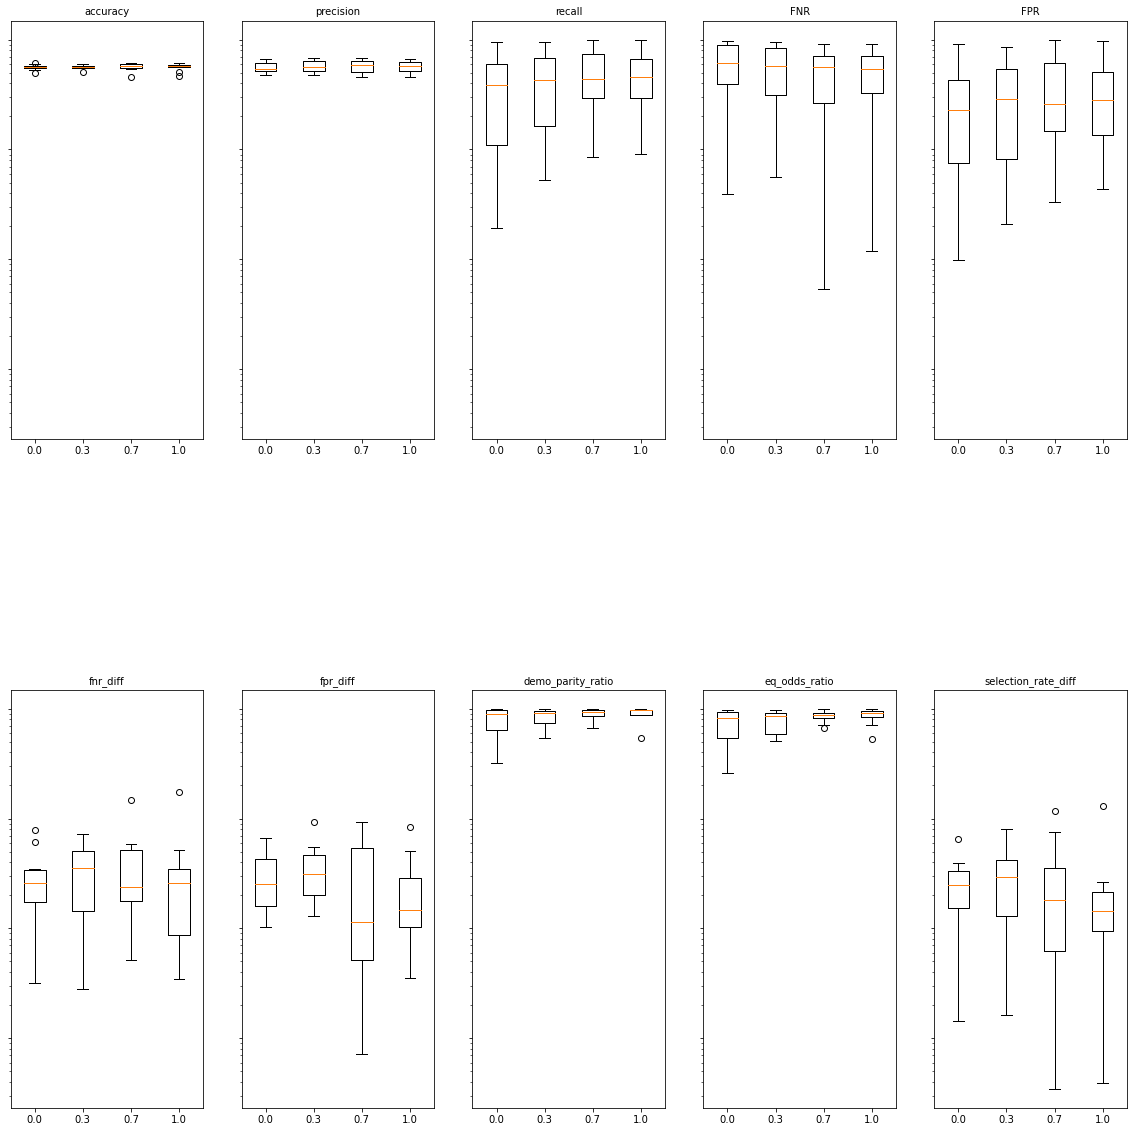

In [ ]:
#@markdown ### Plot all our metrics as line plots while varying alpha
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(20, 20), sharey=True)

#metrics name and alpha values as labels
metrics_overall = ['accuracy','precision','recall','FNR','FPR',
  'fnr_diff','fpr_diff','demo_parity_ratio','eq_odds_ratio','selection_rate_diff']
labels = ['0.0', '0.3', '0.7', '1.0']
    
#draw plot
for j in range(0,10):
    if (j<5):
        #prepare data
        df_overall_graph = df_af_overall[[metrics_overall[j],'alpha','random_seed']]
        df_piv = df_overall_graph.pivot(index='random_seed', columns='alpha')
        df_piv = df_piv[metrics_overall[j]].reset_index(drop=True)
        #plot subplot
        axs[0, j].boxplot(df_piv, labels=labels)
        axs[0, j].set_title(metrics_overall[j], fontsize=10)
    else:
        df_overall_graph = df_af_overall[[metrics_overall[j],'alpha','random_seed']]
        df_piv = df_overall_graph.pivot(index='random_seed', columns='alpha')
        df_piv = df_piv[metrics_overall[j]].reset_index(drop=True)
        
        axs[1, (j-5)].boxplot(df_piv, labels=labels)
        axs[1, (j-5)].set_title(metrics_overall[j], fontsize=10)
            
for ax in axs.flat:
    ax.set_yscale('log')
    ax.set_yticklabels([])

fig.subplots_adjust(hspace=0.6)
plt.show()

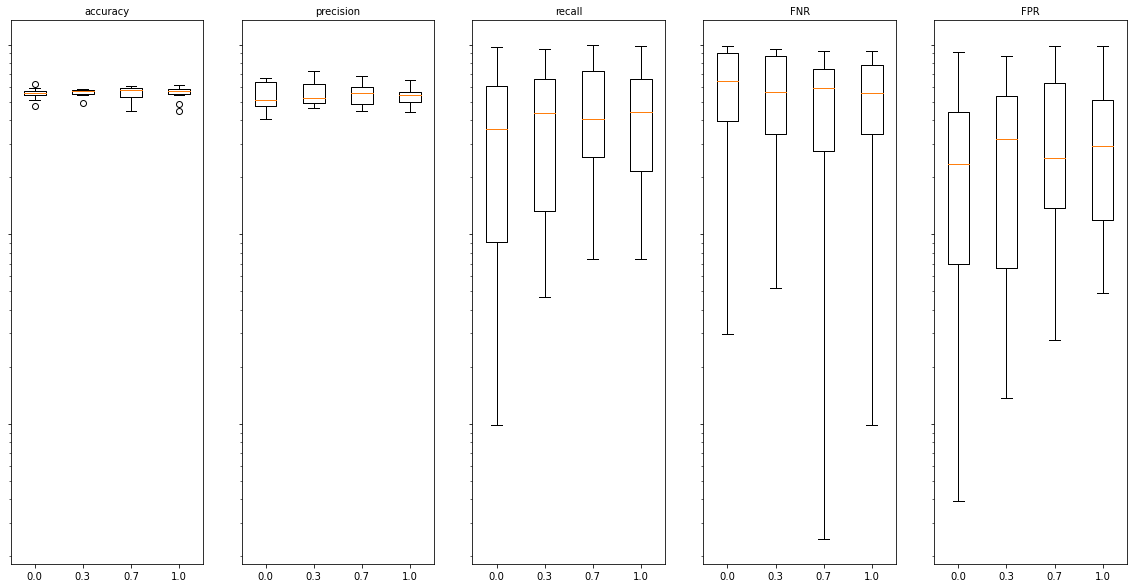

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(20, 10), sharey=True)

#metrics name and alpha values as labels
metrics_sen = ['accuracy','precision','recall','FNR','FPR']
labels = ['0.0', '0.3', '0.7', '1.0']

df_af_male = df_af_sen[df_af_sen.gender_Female == 0].drop('gender_Female', axis=1)
#draw plot
for j in range(0,5):
    #prepare data
    df_af_male_graph = df_af_male[[metrics_sen[j],'alpha','random_seed']]
    df_piv = df_af_male.pivot(index='random_seed', columns='alpha')
    df_piv = df_piv[metrics_sen[j]].reset_index(drop=True)
    #draw subplot    
    axs[j].boxplot(df_piv, labels=labels)
    axs[j].set_title(metrics_sen[j], fontsize=10)
            
for ax in axs.flat:
    ax.set_yscale('log')
    ax.set_yticklabels([])

fig.subplots_adjust(hspace=0.6)
plt.show()

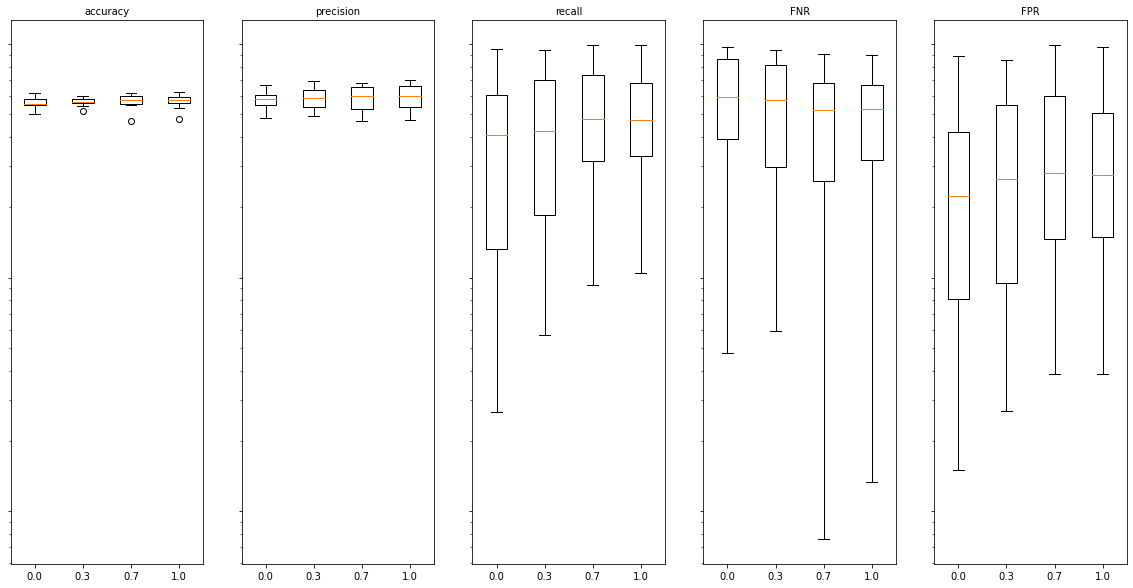

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(20, 10), sharey=True)

df_af_female = df_af_sen[df_af_sen.gender_Female == 1].drop('gender_Female', axis=1)
#draw plot
for j in range(0,5):
    #prepare data
    df_af_female_graph = df_af_female[[metrics_sen[j],'alpha','random_seed']]
    df_piv = df_af_female.pivot(index='random_seed', columns='alpha')
    df_piv = df_piv[metrics_sen[j]].reset_index(drop=True)
    #plot data
    axs[j].boxplot(df_piv, labels=labels)
    axs[j].set_title(metrics_sen[j], fontsize=10)
            
for ax in axs.flat:
    ax.set_yscale('log')
    ax.set_yticklabels([])

fig.subplots_adjust(hspace=0.6)
plt.show()

The 3 graphs show different levels of alpha and their respective box & whisker plots of fairness metrics. The First graph contains overall metrics I-X, the second graph contains metrics I-V for male, and the third graph contains metrics I-V for female.

For overall performance of metrics, we see that accuracy, precision, demographic parity ratio, and equalized odds ratio have relatively centered distributions, and different alpha did not have much of impact of these metrics. Other metrics have rather wide range over all alpha levels. Recal and FPR follow a pretty clear pattern with change of alpha values that higher alpha have more centered distribution of metrics. Demographic parity ratio, and equalized odds ratio also have smaller range as alpha increases. FNR, on the other hand, have more concentrated distribution with lower alpha (smallest range with alpha = 0.3). Other overall metrics does not have much pattern with the change of alpha. 

For metrics grouped by gender, we are also discerning similar patterns with the change of alpha, and the distirbution of these metrics are quite similar cross two genders. Female FPR hvae overall a smaller range than male FPR across all alpha levels.

Comparing our box & whisker graph to the metrics obtained by optimized random forest estimator in (b), we see that metrics obatined in (b) are all slightly higher than the Adversarial fairness classifier for accuracy, precision (metrics from (b) at upper quartile). Recall, FNR, FPR, demographic parity ratio and equalized odds ratio have mean around the optimized random forest metric. The optimized random forest metric is higher in false positive rate difference, and much higher in false negative rate difference and selection rate difference. The similar situation also applies to both male and female metrics. Thus we do see certain improvements in fairness metrics than out optimzed random forest model.


# Problem 2, Part (d) 
### **Threshold Optimizer Post-processing intervention**



In [ ]:
#@markdown Fit the ThresholdOptimizer model here
#create table to store values
df_to_overall = pd.DataFrame(columns = ['accuracy','precision','recall','FNR','FPR',
  'fnr_diff','fpr_diff','demo_parity_ratio','eq_odds_ratio','selection_rate_diff'])
df_to_sen = pd.DataFrame(columns = ['accuracy','precision','recall','FNR','FPR','random_seed'])
#looping over 10 seeds
for i in range(0,10):
    X_train, X_test, y_train, y_test = train_test_split(x_numeric, y_raw, test_size=0.2, random_state=0)
    # Train a model on straightforward data
    default_model = RandomForestClassifier(n_estimators = 1000, max_depth = 10).fit(X_train, y_train)

    # Make the post-processed model
    postprocessed_model = ThresholdOptimizer(
        estimator=default_model,
        constraints='false_negative_rate_parity',
        objective='balanced_accuracy_score',
        prefit=True,
        predict_method='predict_proba')

    # Fit the model to the training data
    postprocessed_model.fit(X_train, y_train, sensitive_features=X_train['gender_Female'])

    # Predict on the test data
    y_pred_to = postprocessed_model.predict(X_test, sensitive_features=X_test['gender_Female'])  


    # Make a metricframe
    grouped_on_sex_to = MetricFrame(
        metrics=metric_dict,
        y_true=y_test,
        y_pred=y_pred_to,
        sensitive_features=sensitive_feature)

    #fairness metric vi-x
    fnr_diff_to = false_negative_rate_difference(y_test, y_pred_to, sensitive_features=X_test.gender_Female)
    fpr_diff_to = false_positive_rate_difference(y_test, y_pred_to, sensitive_features=X_test.gender_Female)
    demo_parity_ratio_to = demographic_parity_ratio(y_test, y_pred_to, sensitive_features=X_test.gender_Female)
    eq_odds_ratio_to = equalized_odds_ratio(y_test, y_pred_to, sensitive_features=X_test.gender_Female)
    selection_rate_diff_to = selection_rate_difference(y_test, y_pred_to, sensitive_features=X_test.gender_Female)

    #concatenate into an entry for table
    arr_to_overall = np.append(grouped_on_sex_to.overall, [fnr_diff_to,fpr_diff_to,demo_parity_ratio_to,
                                                      eq_odds_ratio_to,selection_rate_diff_to])
    #append entry
    df_to_overall.loc[len(df_to_overall)] = arr_to_overall

    #table for sensitive feature fairness metrics
    df_to_group = grouped_on_sex_to.by_group.reset_index()
    df_to_group = df_to_group.assign(random_seed = i)
    df_to_sen = pd.concat([df_to_sen,df_to_group])

#assign random seed accordingly
df_to_overall['random_seed'] = np.repeat(np.arange(0, 10), 1)

In [ ]:
#TO overall table
df_to_overall

,accuracy,precision,recall,FNR,FPR,fnr_diff,fpr_diff,demo_parity_ratio,eq_odds_ratio,selection_rate_diff,random_seed
0,0.603635,0.554386,0.678840,0.321160,0.459729,0.030287,0.001975,0.964375,0.956234,0.020271,0
1,0.610511,0.563653,0.656284,0.343716,0.428054,0.020955,0.001645,0.970207,0.968508,0.016077,1
2,0.600688,0.550950,0.685285,0.314715,0.470588,0.019842,0.007501,0.968064,0.971405,0.018428,2
3,0.613949,0.566453,0.663802,0.336198,0.428054,0.047374,0.005289,0.944935,0.930782,0.030254,3
4,0.614440,0.566972,0.663802,0.336198,0.427149,0.029893,0.003673,0.967877,0.955833,0.017449,4
5,0.602161,0.553778,0.669173,0.330827,0.454299,0.013177,0.010143,0.969929,0.977901,0.016843,5
6,0.604617,0.554688,0.686359,0.313641,0.464253,0.039225,0.010350,0.949947,0.944238,0.028971,6
7,0.613949,0.566453,0.663802,0.336198,0.428054,0.016782,0.008932,0.966293,0.974994,0.018339,7
8,0.606582,0.561553,0.636950,0.363050,0.419005,0.017326,0.010400,0.964063,0.973116,0.018945,8
9,0.606090,0.555460,0.693878,0.306122,0.467873,0.013200,0.001167,0.980967,0.981133,0.010966,9


In [ ]:
#table for sensitive feature
df_to_sen

,accuracy,precision,recall,FNR,FPR,random_seed,gender_Female
0,0.594743,0.53493,0.661728,0.338272,0.458661,0,0.0
1,0.610864,0.56964,0.692015,0.307985,0.460637,0,1.0
0,0.6046,0.546025,0.644444,0.355556,0.427165,1,0.0
1,0.615316,0.577558,0.665399,0.334601,0.428811,1,1.0
0,0.595838,0.535294,0.674074,0.325926,0.466535,2,0.0
1,0.60463,0.563272,0.693916,0.306084,0.474037,2,1.0
0,0.60241,0.544304,0.637037,0.362963,0.425197,3,0.0
1,0.62333,0.583468,0.684411,0.315589,0.430486,3,1.0
0,0.6046,0.545833,0.646914,0.353086,0.429134,4,0.0
1,0.62244,0.583607,0.676806,0.323194,0.425461,4,1.0


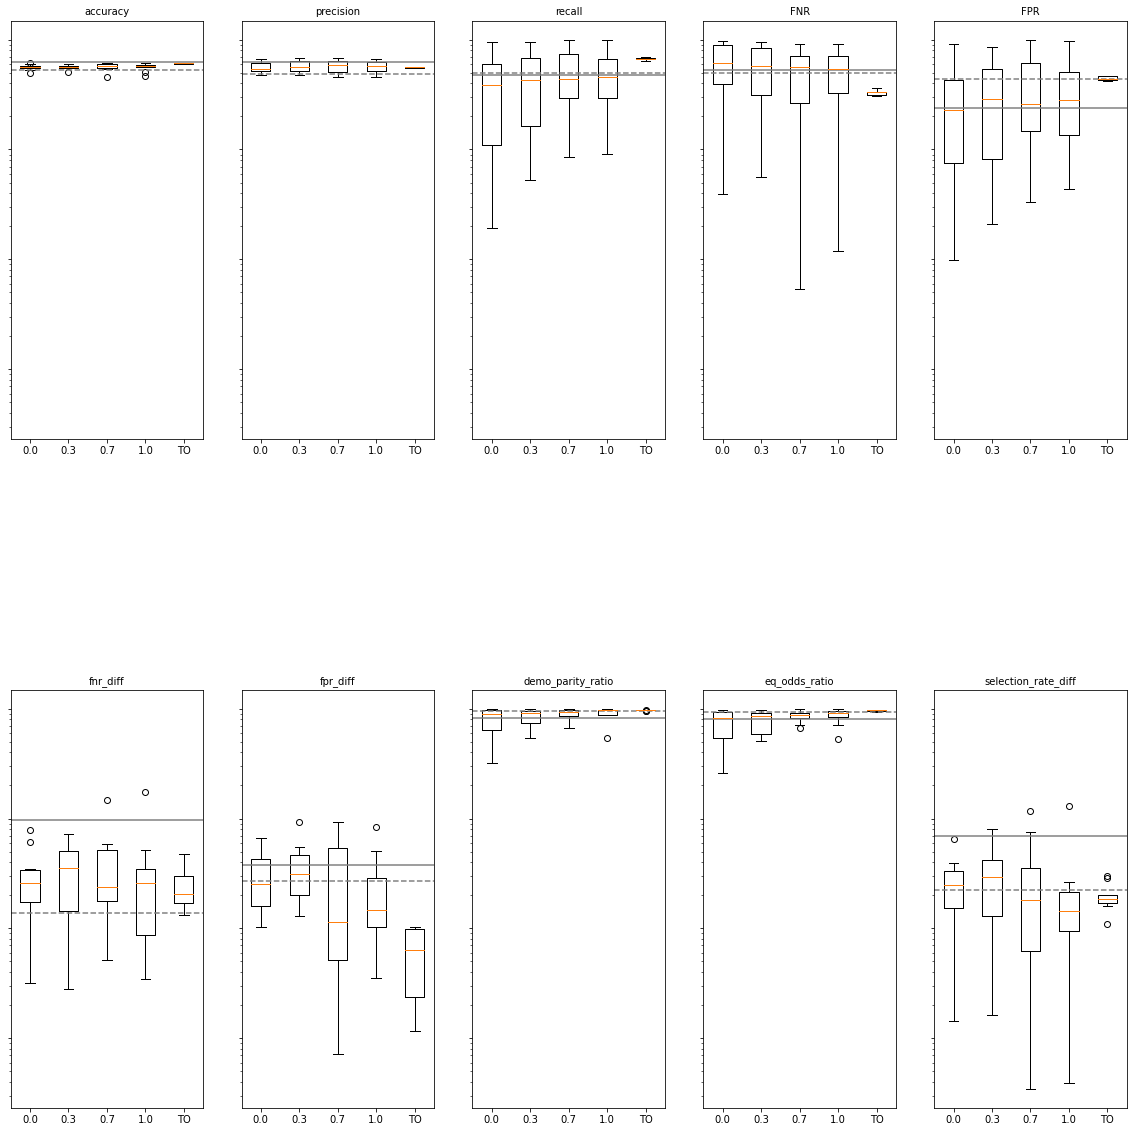

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(20, 20), sharey=True)

#metrics name and alpha values as labels
metrics_overall = ['accuracy','precision','recall','FNR','FPR',
  'fnr_diff','fpr_diff','demo_parity_ratio','eq_odds_ratio','selection_rate_diff']
labels = ['0.0', '0.3', '0.7', '1.0','TO']
#metrics vi-x
baseline_metric_vix = [fnr_diff_baseline, fpr_diff_baseline, demo_parity_ratio_baseline, 
                       eq_odds_ratio_baseline, selection_rate_diff_baseline]
metric_vix = [fnr_diff, fpr_diff, demo_parity_ratio, 
                eq_odds_ratio, selection_rate_diff]

#draw plot
for j in range(0,10):
    if (j<5):
        #prepare data
        df_overall_graph = df_af_overall[[metrics_overall[j],'alpha','random_seed']]
        df_piv = df_overall_graph.pivot(index='random_seed', columns='alpha')
        df_piv = df_piv[metrics_overall[j]].reset_index(drop=True)
        df_piv = df_piv.assign(ThresholdOptimizer = df_to_overall[metrics_overall[j]])
        #plot subplot
        axs[0, j].boxplot(df_piv, labels=labels)
        axs[0, j].axhline(y=metric_frame_baseline.overall[j], color='grey', linestyle='dashed')
        axs[0, j].axhline(y=metric_frame.overall[j], color='grey', linestyle='-')
        axs[0, j].set_title(metrics_overall[j], fontsize=10)
    else:
        df_overall_graph = df_af_overall[[metrics_overall[j],'alpha','random_seed']]
        df_piv = df_overall_graph.pivot(index='random_seed', columns='alpha')
        df_piv = df_piv[metrics_overall[j]].reset_index(drop=True)
        df_piv = df_piv.assign(ThresholdOptimizer = df_to_overall[metrics_overall[j]])
        
        axs[1, (j-5)].boxplot(df_piv, labels=labels)
        axs[1, (j-5)].axhline(y=baseline_metric_vix[j-5], color='grey', linestyle='dashed')
        axs[1, (j-5)].axhline(y=metric_vix[j-5], color='grey', linestyle='-')
        axs[1, (j-5)].set_title(metrics_overall[j], fontsize=10)
            
for ax in axs.flat:
    ax.set_yscale('log')
    ax.set_yticklabels([])

fig.subplots_adjust(hspace=0.6)
plt.show()

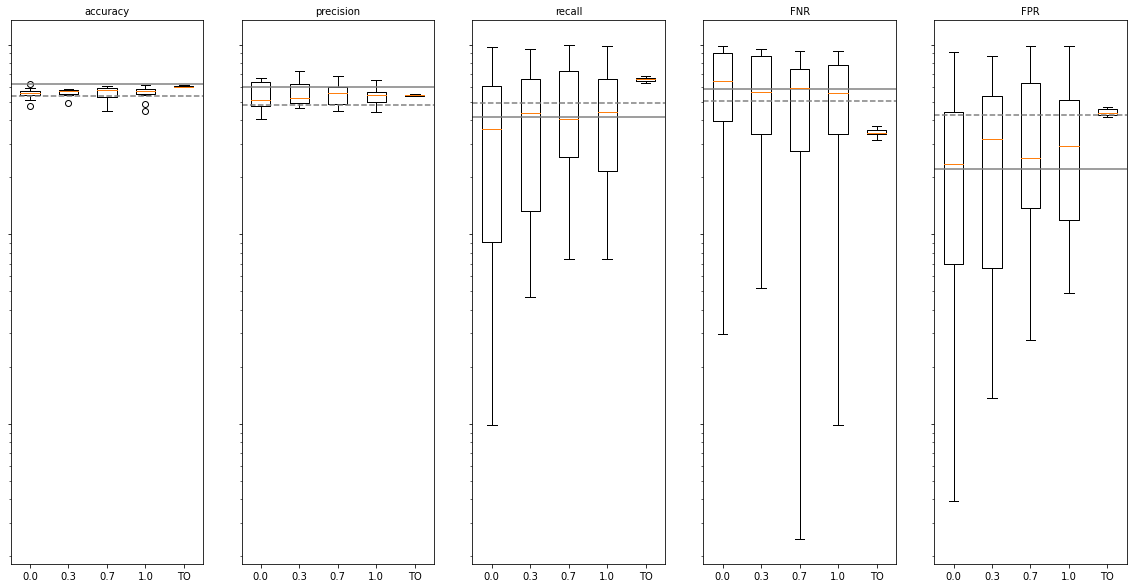

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(20, 10), sharey=True)

#metrics name and alpha values as labels
metrics_sen = ['accuracy','precision','recall','FNR','FPR']
labels = ['0.0', '0.3', '0.7', '1.0','TO']
#data for baseline group by gender
df_baseline = metric_frame_baseline.by_group.reset_index()
baseline_male = df_baseline[df_baseline.gender_Female == 0].drop('gender_Female', axis = 1).to_numpy()
baseline_female = df_baseline[df_baseline.gender_Female == 1].drop('gender_Female', axis = 1).to_numpy()
#data for optimized group by gender
df_tune = metric_frame.by_group.reset_index()
tune_male = df_tune[df_tune.gender_Female == 0].drop('gender_Female', axis = 1).to_numpy()
tune_female = df_tune[df_tune.gender_Female == 1].drop('gender_Female', axis = 1).to_numpy()

#male threshold optimizer data
df_to_male = df_to_sen[df_to_sen.gender_Female == 0].drop('gender_Female', axis=1).reset_index()
#draw plot
for j in range(0,5):
    #prepare data
    df_af_male_graph = df_af_male[[metrics_sen[j],'alpha','random_seed']]
    df_piv = df_af_male.pivot(index='random_seed', columns='alpha')
    df_piv = df_piv[metrics_sen[j]].reset_index(drop=True)
    df_piv = df_piv.assign(ThresholdOptimizer = df_to_male[metrics_sen[j]])
    #draw subplot    
    axs[j].boxplot(df_piv, labels=labels)
    axs[j].axhline(y=baseline_male[0][j], color='grey', linestyle='dashed')
    axs[j].axhline(y=tune_male[0][j], color='grey', linestyle='-')
    axs[j].set_title(metrics_sen[j], fontsize=10)
            
for ax in axs.flat:
    ax.set_yscale('log')
    ax.set_yticklabels([])

fig.subplots_adjust(hspace=0.6)
plt.show()

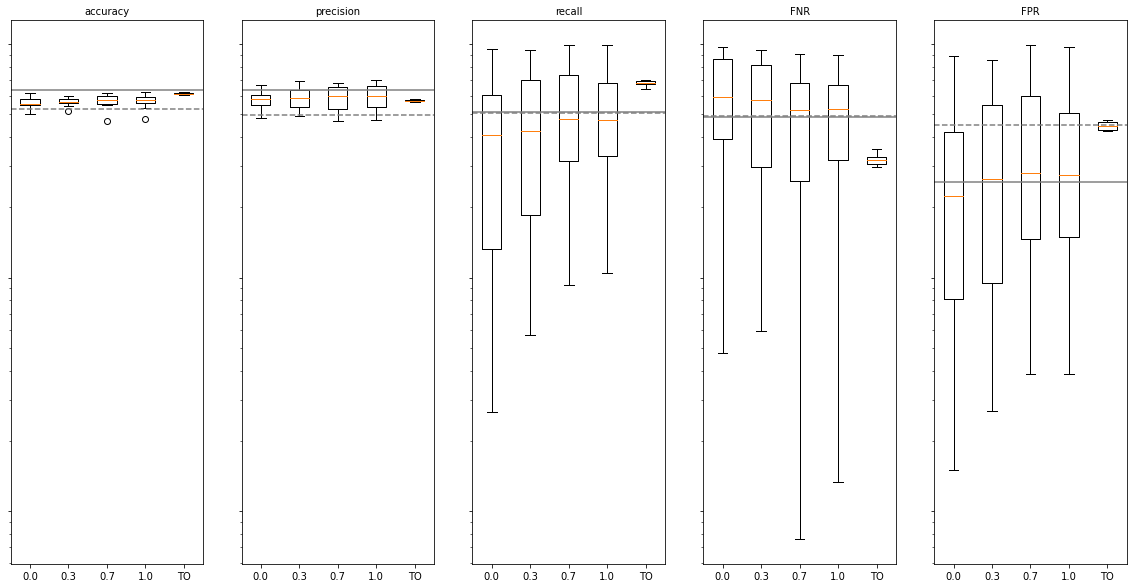

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(20, 10), sharey=True)
#female threshold optimizer data
df_to_female = df_to_sen[df_to_sen.gender_Female == 1].drop('gender_Female', axis=1).reset_index()
#draw plot
for j in range(0,5):
    df_af_female_graph = df_af_female[[metrics_sen[j],'alpha','random_seed']]
    df_piv = df_af_female.pivot(index='random_seed', columns='alpha')
    df_piv = df_piv[metrics_sen[j]].reset_index(drop=True)
    df_piv = df_piv.assign(ThresholdOptimizer = df_to_female[metrics_sen[j]])
        
    axs[j].boxplot(df_piv, labels=labels)
    axs[j].axhline(y=baseline_female[0][j], color='grey', linestyle='dashed')
    axs[j].axhline(y=tune_female[0][j], color='grey', linestyle='-')
    axs[j].set_title(metrics_sen[j], fontsize=10)
            
for ax in axs.flat:
    ax.set_yscale('log')
    ax.set_yticklabels([])

fig.subplots_adjust(hspace=0.6)
plt.show()

The First graph contains overall metrics I-X, the second graph contains metrics I-V for male, and the third graph contains metrics I-V for female.

For the constraint of ThresholdOptimizer, false negative rate parity is chosen to optimize. Given the medical context in this classification scenario, we are trying to predict if a patient diagnosed with diabetes have a hospital admission, would he/she be readmitted to hospital in the next 30 days. Intuitively for patients, it is crucial not to have a false negative case, that is, if patient is predicted of no need to readmit but actually do need readmission, directly impacting patient's heath. The fairness tree by Aequitas publisher also suggest that false negative rate parity is the most suitable metric to optimize, since we have an assitive intervention, and we are most concerned with ensuring predictive equity for people with need. Thus for sensitive attribute gender, we want to ensure an optimized false positive rate parity.

Comparing ThresholdOptimizer metrics to Adversatial Fairness classifier metrics, we see that the box plots are all significantly smaller. Accuracy, , precison, false negative rage difference have ThresholdOptimizer metrics around the mean of dversatial Fairness classifier metrics. Recall, false positive rate, demographic parity ratio, equalized odds ratio, and selection rate difference have ThresholdOptimizer metrics slightly higher than dversatial Fairness classifier metrics (around upper quartile). False negative rate and false positive difference, however, have ThresholdOptimizer metrics slightly lower than dversatial Fairness classifier metrics. Similar situation applies to both male and female metrics. 

Comparing ThresholdOptimizer metrics to our optimized random forest model, we see that with approximately the same accuracy, ThresholdOptimizer have a higher false positive rate and lower false negative rate. Therefore we indeed optimzed our false negative rate parity while having a smaller range of metrics than Adversatial Fairness classifier metrics.

**Conclusion**

In general, we see that there is a tradeoff between model prediction perfomances (such as accuracy) and fairness metrics (such as false negative rate parity). In this medical scenario, we have focused our attention on false negative rate parity for our sensitive attribute gender. While accuracy optimized random forest classifier do have higher accuracy, fairness metircs suffer. The Adversarial Fairness classifier indeed improved fairness metrics while have approximately the same accuracy, and ThresholdOptimizer further optimized our constraint (false negative rate parity) with approximately the same accuracy and also more concentrated distribution of metrics.